# Assignment 1: Chromosome Structures

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import os
import sys

## Question 1: Chromosome structures 

In [ ]:
# list all the files that ends with .size
from os import name


size_files = [f for f in os.listdir() if f.endswith(".sizes")]
# load each file and add a column with the first segment of the file name
df_sizes = pd.concat(
    [
        pd.read_csv(f, sep="\t", header=None).assign(species=f.split(".")[0])
        for f in size_files
    ],
    ignore_index=True,
)
df_sizes.columns = ["chrom", "size", "species"]
# df_sizes

### Question 1.1. Total genome size per species

In [3]:
df_sizes.groupby("species")["size"].sum()

species
TAIR10      119146348
ce10        100286070
dm6         137547960
ecoli         4639211
hg38       3088269832
tomato      782520033
wheat     14547261565
yeast        12157105
Name: size, dtype: int64

### Question 1.2. Number of chromosomes

In [4]:
df_sizes.groupby("species")["chrom"].count()

species
TAIR10     5
ce10       7
dm6        7
ecoli      1
hg38      24
tomato    13
wheat     22
yeast     17
Name: chrom, dtype: int64

### Question 1.3. Largest chromosome size and name

In [5]:
idx = df_sizes.groupby("species")["size"].idxmax()
df_sizes.loc[idx, ["species", "chrom", "size"]].reset_index(drop=True)

,species,chrom,size
0,TAIR10,Chr1,30427671
1,ce10,chrV,20924149
2,dm6,chr3R,32079331
3,ecoli,Ecoli,4639211
4,hg38,chr1,248956422
5,tomato,ch01,90863682
6,wheat,3B,830829764
7,yeast,chrIV,1531933


### Question 1.4. Smallest chromosome size and name

In [6]:
idx = df_sizes.groupby("species")["size"].idxmin()
df_sizes.loc[idx, ["species", "chrom", "size"]].reset_index(drop=True)

,species,chrom,size
0,TAIR10,Chr4,18585056
1,ce10,chrM,13794
2,dm6,chr4,1348131
3,ecoli,Ecoli,4639211
4,hg38,chr21,46709983
5,tomato,ch00,9643250
6,wheat,6D,473592718
7,yeast,chrM,85779


### Question 1.5. Mean chromosome length

In [7]:
df_sizes.groupby("species")["size"].mean()

species
TAIR10    2.382927e+07
ce10      1.432658e+07
dm6       1.964971e+07
ecoli     4.639211e+06
hg38      1.286779e+08
tomato    6.019385e+07
wheat     6.612392e+08
yeast     7.151238e+05
Name: size, dtype: float64

## Question 2. Coverage simulator 

### Question 2.1. How many 100bp reads are needed to sequence a 1Mbp genome to 3x coverage?

In [8]:
genome_size = 1_000_000  # 1Mbp
coverage = 3
read_length = 100  # 100bp

# Calculate the number of reads needed
num_reads = (genome_size * coverage) // read_length
num_reads

30000

### Question 2.2. In the language of your choice, simulate sequencing 3x coverage of a 1Mbp genome with 100bp reads and plot the histogram of coverage. Note you do not need to actually output the sequences of the reads, you can just uniform randomly sample positions in the genome and record the coverage. You do not need to consider the strand of each read. The start position of each read should have a uniform random probability at each possible starting position (1 through 999,901). You can record the coverage in an array of 1M positions. Overlay the histogram with a Poisson distribution with lambda=3. Also overlay the distribution with a Normal distribution with a mean of 3 and a standard deviation of 1.73 (which is the square root of 3). Here is the pseudocode for the simulator:

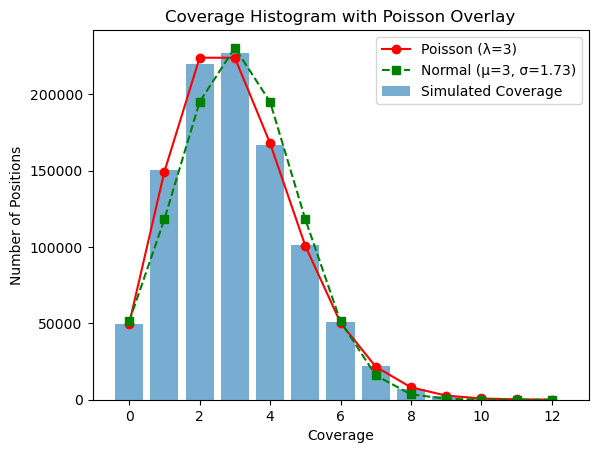

In [ ]:
# Initialize coverage array for the genome
genome_coverage = np.zeros(genome_size, dtype=int)

# Simulate sequencing reads
for _ in range(num_reads):
    startpos = np.random.randint(0, genome_size - read_length + 1)
    endpos = startpos + read_length
    genome_coverage[startpos:endpos] += 1

max_coverage = genome_coverage.max()

# Histogram: count how many positions have 0x, 1x, 2x, ... coverage
histogram = np.zeros(max_coverage + 1, dtype=int)
for cov in genome_coverage:
    histogram[cov] += 1

# Plotting the histogram with overlay poisson(lambda=3) on top
plt.bar(range(len(histogram)), histogram, label="Simulated Coverage", alpha=0.6)

# Overlay Poisson distribution with lambda=3
poisson_lambda = coverage
x = np.arange(0, max_coverage + 1)
poisson_pmf = stats.poisson.pmf(x, poisson_lambda)
poisson_scaled = poisson_pmf * genome_size  # scale to genome size


plt.plot(x, poisson_scaled, "r-", marker="o", label="Poisson (λ=3)")

# Overlay Normal distribution with mu=3, sigma=1.73
mu = 3
sigma = 1.73
normal_pdf = stats.norm.pdf(x, mu, sigma)
normal_scaled = normal_pdf * genome_size  # scale to genome size
plt.plot(x, normal_scaled, "g--", marker="s", label="Normal (μ=3, σ=1.73)")

plt.xlabel("Coverage")
plt.ylabel("Number of Positions")
plt.title("Coverage Histogram with Poisson Overlay")
plt.legend()
plt.show()

### Question 2.3. Using the histogram from Q2.2, how much of the genome has not been sequenced (has 0x coverage)? How well does this match Poisson expectations? How well does the normal distribution fit the data?

In [10]:
print("Number of positions with 0x coverage:", histogram[0])
print("Expected number of positions with 0x coverage (Poisson):", poisson_scaled[0])
print("Expected number of positions with 0x coverage (Normal):", normal_scaled[0])

# Calculate the difference between observed and expected
print("Difference (Poisson):", sum(abs(histogram - poisson_scaled)))
print("Difference (Normal):", sum(abs(histogram - normal_scaled)))

Number of positions with 0x coverage: 49682
Expected number of positions with 0x coverage (Poisson): 49787.06836786395
Expected number of positions with 0x coverage (Normal): 51271.59605350212
Difference (Poisson): 11751.421550397525
Difference (Normal): 120182.29095992222


The result from the simulation is much closer to the Poisson expectations than to the Normal distribution. This is likely due to the nature of sequencing coverage, which is more accurately modeled by a Poisson process, especially at low coverage levels.

### Question 2.4. Now repeat the analysis with 10x coverage: 1. simulate the appropriate number of reads, 2. make a histogram, 3. overlay a Poisson distribution with lambda=10, 4. overlay with a Normal distribution with mean=10, standard deviation=3.16. 5. compute the number of bases with 0x coverage, and 6. evaluate how well it matches the Poisson expectation and Normal expectations.

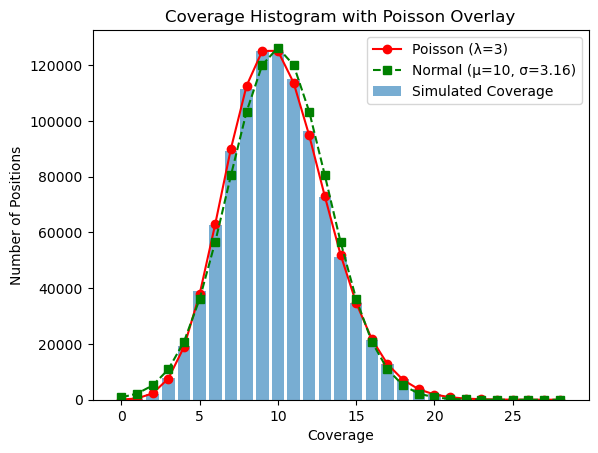

Number of positions with 0x coverage: 50
Expected number of positions with 0x coverage (Poisson): 45.39992976248485
Expected number of positions with 0x coverage (Normal): 844.537900288904
Difference (Poisson): 9799.61211651328
Difference (Normal): 77683.57296914629


In [11]:
# Initialize coverage array for the genome
genome_coverage = np.zeros(genome_size, dtype=int)
coverage = 10
num_reads = (genome_size * coverage) // read_length  # for 10x coverage
# Simulate sequencing reads
for _ in range(num_reads):
    startpos = np.random.randint(0, genome_size - read_length + 1)
    endpos = startpos + read_length
    genome_coverage[startpos:endpos] += 1

max_coverage = genome_coverage.max()

# Histogram: count how many positions have 0x, 1x, 2x, ... coverage
histogram = np.zeros(max_coverage + 1, dtype=int)
for cov in genome_coverage:
    histogram[cov] += 1

# Plotting the histogram with overlay poisson(lambda=3) on top
plt.bar(range(len(histogram)), histogram, label="Simulated Coverage", alpha=0.6)

# Overlay Poisson distribution with lambda=3
poisson_lambda = coverage
x = np.arange(0, max_coverage + 1)
poisson_pmf = stats.poisson.pmf(x, poisson_lambda)
poisson_scaled = poisson_pmf * genome_size  # scale to genome size


plt.plot(x, poisson_scaled, "r-", marker="o", label="Poisson (λ=3)")

# Overlay Normal distribution with mu=10, sigma=3.16
mu = coverage
sigma = 3.16
normal_pdf = stats.norm.pdf(x, mu, sigma)
normal_scaled = normal_pdf * genome_size  # scale to genome size
plt.plot(x, normal_scaled, "g--", marker="s", label="Normal (μ=10, σ=3.16)")

plt.xlabel("Coverage")
plt.ylabel("Number of Positions")
plt.title("Coverage Histogram with Poisson Overlay")
plt.legend()
plt.show()

print("Number of positions with 0x coverage:", histogram[0])
print("Expected number of positions with 0x coverage (Poisson):", poisson_scaled[0])
print("Expected number of positions with 0x coverage (Normal):", normal_scaled[0])

# Calculate the difference between observed and expected
print("Difference (Poisson):", sum(abs(histogram - poisson_scaled)))
print("Difference (Normal):", sum(abs(histogram - normal_scaled)))

The number of non-covered positions (0x coverage) is:", histogram[0], much smaller than the previous simulation. It's still closer to the Poisson expectation than to the Normal distribution but the gap has narrowed compared to the 3x coverage case.

### Question 2.5. Now repeat the analysis with 30x coverage: 1. simulate the appropriate number of reads, 2. make a histogram, 3. overlay a Poisson distribution with lambda=30, 4. overlay with a Normal distribution with mean=30, standard deviation=5.47 5. compute the number of bases with 0x coverage, and 6. evaluate how well it matches the Poisson expectation and Normal expectations.

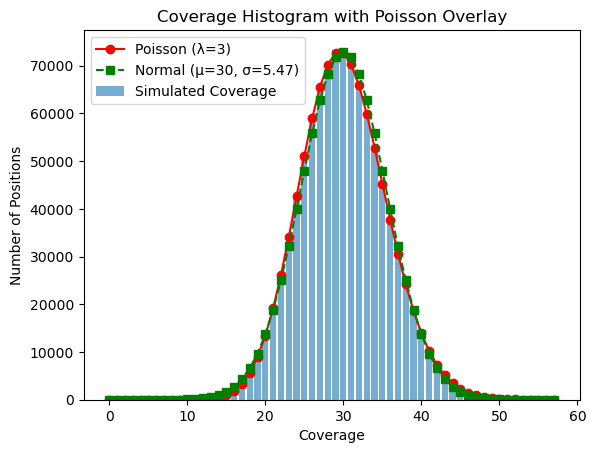

Number of positions with 0x coverage: 4
Expected number of positions with 0x coverage (Poisson): 9.357622968840174e-08
Expected number of positions with 0x coverage (Normal): 0.021442911648056763
Difference (Poisson): 9485.158174798837
Difference (Normal): 42009.51342738423


In [12]:
# Initialize coverage array for the genome
genome_coverage = np.zeros(genome_size, dtype=int)
coverage = 30
num_reads = (genome_size * coverage) // read_length  # for 30x coverage
# Simulate sequencing reads
for _ in range(num_reads):
    startpos = np.random.randint(0, genome_size - read_length + 1)
    endpos = startpos + read_length
    genome_coverage[startpos:endpos] += 1

max_coverage = genome_coverage.max()

# Histogram: count how many positions have 0x, 1x, 2x, ... coverage
histogram = np.zeros(max_coverage + 1, dtype=int)
for cov in genome_coverage:
    histogram[cov] += 1

# Plotting the histogram with overlay poisson(lambda=3) on top
plt.bar(range(len(histogram)), histogram, label="Simulated Coverage", alpha=0.6)

# Overlay Poisson distribution with lambda=3
poisson_lambda = coverage
x = np.arange(0, max_coverage + 1)
poisson_pmf = stats.poisson.pmf(x, poisson_lambda)
poisson_scaled = poisson_pmf * genome_size  # scale to genome size


plt.plot(x, poisson_scaled, "r-", marker="o", label="Poisson (λ=3)")

# Overlay Normal distribution with mu=30, sigma=5.47
mu = coverage
sigma = 5.47
normal_pdf = stats.norm.pdf(x, mu, sigma)
normal_scaled = normal_pdf * genome_size  # scale to genome size
plt.plot(x, normal_scaled, "g--", marker="s", label="Normal (μ=30, σ=5.47)")

plt.xlabel("Coverage")
plt.ylabel("Number of Positions")
plt.title("Coverage Histogram with Poisson Overlay")
plt.legend()
plt.show()

print("Number of positions with 0x coverage:", histogram[0])
print("Expected number of positions with 0x coverage (Poisson):", poisson_scaled[0])
print("Expected number of positions with 0x coverage (Normal):", normal_scaled[0])

# Calculate the difference between observed and expected
print("Difference (Poisson):", sum(abs(histogram - poisson_scaled)))
print("Difference (Normal):", sum(abs(histogram - normal_scaled)))

## Question 3: Kmer Uniqueness

### Question 3.1. How many As, Cs, Gs, Ts and Ns are found in the entire chromosome? If needed convert lowercase letters to uppercase, and any other character can be converted to N.

In [ ]:
# load "chr22.fa" as a continuous string
with open("chr22.fa", "r") as f:
    chr22 = f.read().replace("\n", "")
# remove the first ">chr22""
chr22 = chr22[6:]
# convert all characters to uppercase
chr22 = chr22.upper()
# count the number of each character in the genome with default dictionary
from collections import defaultdict

char_count = defaultdict(int)
for i in range(len(chr22)):
    char = chr22[i]
    char_count[char] += 1
# show the character counts
for char, count in char_count.items():
    print(f"{char}: {count}")

N: 11658691
G: 9246186
A: 10382214
T: 10370725
C: 9160652


### Question 3.2. In the language of your choice, tally the frequency of 19-mers in the chromosome, and output the kmer frequency spectrum upto 1000 e.g. how many kmers occur 1 time, how many occur 2 times, how many occur 3 times, etc. For this, convert lowercase letters to uppercase, and any character that is not ACG or T can be converted to A (especially N characters). We recommend you use a dictionary (or hash table) to tally the frequencies using this pseudocode. In your writeup, show the kmer frequency spectrum for 1 to 20, e.g. how many kmers occur 1 time, how many occur 2, ..., how many occur 20 times. This can be done with the unix command head:

In [ ]:
from collections import defaultdict

k = 19

# Read genome, convert to uppercase, convert non-ACGT to 'A'
with open("chr22.fa", "r") as f:
    genome_string = f.read().replace("\n", "")
genome_string = genome_string[6:].upper()  # remove ">chr22" and uppercase
genome_string = "".join([base if base in "ACGT" else "A" for base in genome_string])

# Dictionary to map kmer to frequency

kmer_frequency = defaultdict(int)

# Scan the genome, extract kmers, and tally up their frequencies
for i in range(len(genome_string) - k + 1):
    kmer = genome_string[i : i + k]
    kmer_frequency[kmer] += 1

# Tally the frequencies in a dictionary that maps kmer frequency to count
tally = defaultdict(int)
max_frequency = 0

for freq in kmer_frequency.values():
    tally[freq] += 1
    if freq > max_frequency:
        max_frequency = freq

### Question 3.3. Using the output from 3.2, plot the kmer frequency spectrum: x-axis is the kmer frequency, and the y-axis is the number of kmers that occur x times. Make sure to plot both the x and y-axis in log space.

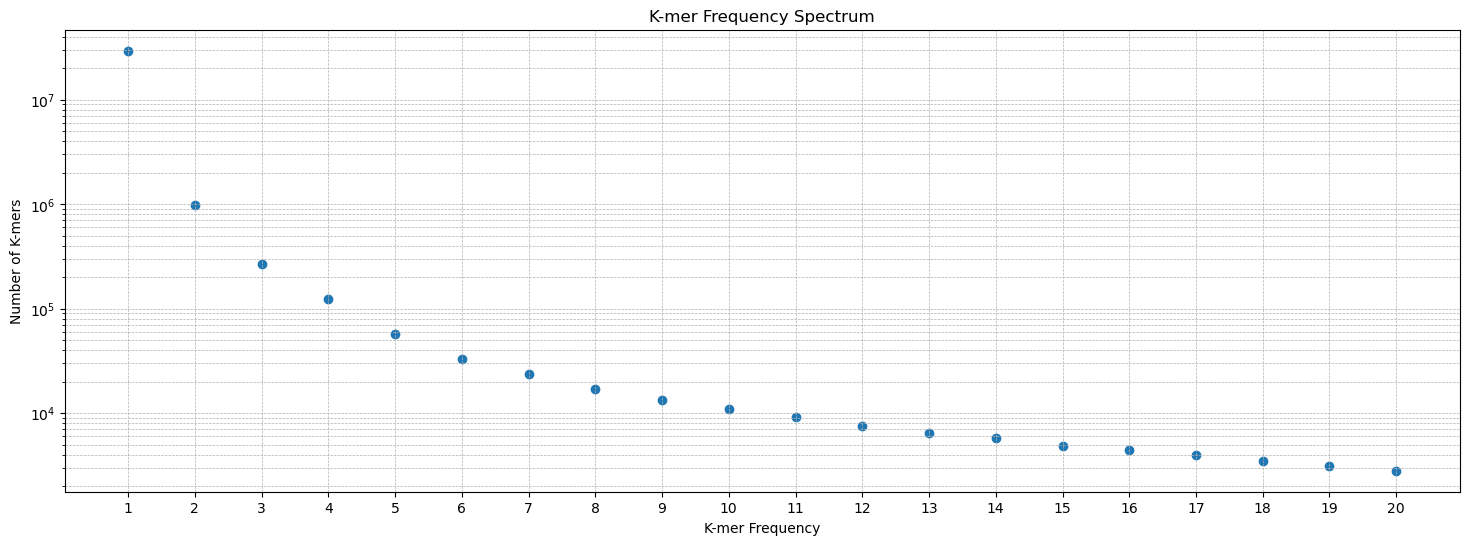

In [ ]:
# plot the kmer frequency spectrum from 1 to 20
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(18, 6))

x = list(np.arange(1, 21))
y = [tally.get(i, 0) for i in x]

plt.scatter(x, y)
# plt.xscale("log")
plt.yscale("log")
plt.xticks(x)
plt.xlabel("K-mer Frequency")
plt.ylabel("Number of K-mers")
plt.title("K-mer Frequency Spectrum")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

### Question 3.4. a) What percent of the genome is unique, e.g. what percent of the kmers occur 1 time. b) What percent of the genome is repetitive (occurs more than 1 time). c) What percent occurs more than 1000 times?

Note: For this analysis, you should separately consider all of the kmers in the genome, e.g. the denominator will be G-k+1. When computing the unique percentage, use the number of unique kmers as the numerator. When computing repetitive percentages, make sure to separately count each instance of a repetitive kmer. For example the string "GCATCATCAT" has kmers: GCA, CAT, ATC, TCA, CAT, ATC, TCA, CAT. Of these 1/8 (12.5%) are unique and 7/8 (87.5%) are repetitive

In [ ]:
# convert the kmer_frequencies to a DataFrame
kmer_df = pd.DataFrame.from_dict(kmer_frequency, orient="index", columns=["count"])
kmer_df.index.name = "kmer"
kmer_df = kmer_df.reset_index()
kmer_df["length"] = kmer_df["kmer"].apply(len)

In [ ]:
n_total_kmers = kmer_df["count"].sum()
# find the number of of kmers that are found only once
n_unique_kmers = kmer_df[kmer_df["count"] == 1].shape[0]
# print the number of unique kmers and its percentage
print(
    f"Total unique kmers: {n_unique_kmers}, Total kmers: {n_total_kmers}, Percentage: {n_unique_kmers / n_total_kmers * 100}"
)
# calculate the number of repetitive kmers (count > 1)
n_repetitive_kmers = n_total_kmers - n_unique_kmers
# print the number of repetitive kmers and its percentage
print(
    f"Total repetitive kmers: {n_repetitive_kmers}, Percentage: {n_repetitive_kmers / n_total_kmers * 100}"
)
# count the number of kmers that occur more than 1000 times
n_highly_repetitive_kmers = kmer_df[kmer_df["count"] > 1000].shape[0]
# print the number of highly repetitive kmers and its percentage
print(
    f"Total highly repetitive kmers: {n_highly_repetitive_kmers}, Percentage: {n_highly_repetitive_kmers / n_total_kmers * 100}"
)

Total unique kmers: 29426883, Total kmers: 50818450, Percentage: 57.905904253278095
Total repetitive kmers: 21391567, Percentage: 42.09409574672191
Total highly repetitive kmers: 489, Percentage: 0.0009622489469867736


## Question 4: Why Genomics?

### Question 4.1. Use ChatGPT (or your favorite LLM) to write an essay on why you are interested in genomics. Make sure to ask for references. Make sure to include both your prompt(s) and the output from the LLM

Prompt:

I became interested in genomic because it's the foundation of what makes who we are and also the sorce of what goes wrong with us. It seems to me like a universal language within all of us. Write a paragraph on why one should be interested in studying genomics. Please cite references. 

Output from ChatGPT 5.0:

Why Study Genomics?

Genomics—the comprehensive study of an organism’s full set of DNA—offers a profound window into the very essence of living systems. It enables us to unravel how genes interact with each other and with the environment to shape both health and identity, transforming our understanding of disease and wellness alike  ￼ ￼. Insights from genomics are opening doors to personalized medicine: predicting disease risk, tailoring treatments based on genetic profiles, and reducing adverse drug effects  ￼. Beyond medicine, genomic knowledge informs public health strategies and accelerates responses to emerging threats—such as using polygenic risk scores to screen for disease risk, or tracing and combating infectious outbreaks with genome-based techniques  ￼. Moreover, genomics extends its reach into agriculture, environmental science, and bioengineering—enhancing crop resilience, enabling environmental cleanup, and unlocking new biotech innovations  ￼ ￼. At its core, studying genomics is an exploration of the fundamental blueprint of life—one that empowers us to understand where we come from, what makes us unique, and how we can shape a healthier, more sustainable future.

⸻

References:
	1. National Human Genome Research Institute. (n.d.). A brief guide to genomics. Genome.gov. Retrieved from https://www.genome.gov/about-genomics/fact-sheets/A-Brief-Guide-to-Genomics  
	2. Wellcome Trust. (2020). Genomics: how unlocking our genes is transforming healthcare. Wellcome.org. Retrieved from https://wellcome.org/news/genomics-how-unlocking-our-genes-transforming-healthcare  
	3. FOMAT Medical Research. (2023). Exploring genomic research: Advancements in genetics. FOMATMedical.com. Retrieved from https://www.fomatmedical.com/news-posts/exploring-genomic-research-advancements-in-genetics  
	4. Lewis, C. M., & Vassos, E. (2020). Polygenic risk scores: From research tools to clinical instruments. Genome Medicine, 12(1), 44. https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-021-00886-y  
	5. Lumen Learning. (n.d.). Risks and benefits of genomic science. In Biology I (OpenStax). Retrieved from https://courses.lumenlearning.com/suny-wmopen-biology1/chapter/risks-and-benefits-of-genomic-science  
	6. Earlham Institute. (2021). How genomics impacts daily life. Earlham.ac.uk. Retrieved from https://www.earlham.ac.uk/articles/how-genomics-impacts-daily-life

⸻



### Question 4.2. Comment on the output from the LLM - does it make logical sense, does it include any phrases you would not have written, do the cited papers exist and support the claims from the LLM?

The output from the LLM makes logical sense and presents a coherent argument for the importance of studying genomics. It highlights key areas where genomics is impactful, such as personalized medicine, public health, and agriculture, though I would have not chosen the same phrasing in some instances. Also there are some phrases that I have not encountered before such as polygenic risk scores. The output emphasizes a lot of the application in health, which makes sense as it's where perhapsthe most immediate and direct benefits are seen.
The references cited appear to be relevant and support the claims made in the text. However, upon checking each cited paper, I noticed that one of the cited article did not exist or had a wrong url (#4) The article itsels does exists, but the url does not lead to the correct page.


### Question 4.3
https://piazza.com/class/meogfdbmu7x7hf/post/11_f7
